In [ ]:
import os

import numpy as np
import pandas as pd
import random

import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

from llm_scores_analysis import * ### all important analysis functions stored here

# Set Up

In [3]:
current_dir = os.getcwd()
if current_dir.endswith("notebooks"):
    prefix = "../"
else:
    prefix = "./"

base_dir = os.path.join(prefix, "summeval-data")
print(base_dir)

full_df = pd.read_json(os.path.join(base_dir, "summeval_processed_full.jsonl"), lines=True)


../summeval-data


In [4]:
N_SUBSET = 300

selected_df = full_df.sample(n=N_SUBSET, random_state=42)
print(len(selected_df))

selected_indices = selected_df.index
print(selected_indices)

300
Index([ 526,  354,  168,  135,  937, 1544, 1253,  237,  478,  650,
       ...
        163, 1296,  266, 1005,  873,  692, 1450, 1263,  192,  548],
      dtype='int64', length=300)


In [5]:
models = [
    "gpt-4o-mini-2024-07-18",
    "gpt-3.5-turbo",
    "mistral-small-latest",
    "mistral-medium-latest",
    "claude-3-5-haiku-20241022"
]

In [6]:
output_dir = "../results/og"  ### Change as needed
score_tables = {}
explain_tables = {}

for model in models:

    score_path = os.path.join(output_dir, f"score_table_{model}.npy")
    explain_path = os.path.join(output_dir, f"explain_table_{model}.npy")

    score_tables[model] = np.load(score_path, allow_pickle=True)
    explain_tables[model] = np.load(explain_path, allow_pickle=True)

    print(f"{model} → Scores shape: {score_tables[model].shape}, Explains shape: {explain_tables[model].shape}")
    
    if np.all(score_tables[model] != -1) and score_tables[model].size > 0 and explain_tables[model].size > 0:
        print(f"[OK]: Scores & explanations loaded successfully.\n")
    else:
        print(f"[WARN]: Missing or invalid data.\n")

gpt-4o-mini-2024-07-18 → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

gpt-3.5-turbo → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

mistral-small-latest → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

mistral-medium-latest → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

claude-3-5-haiku-20241022 → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.



In [7]:
properties_og = ["fluency", "relevance", "coherence", "consistency"]

assertion_dictionary_og = {
    'fluency': {
        'C1-A1': 'Fluency measures the quality of individual sentences, are they well-written and grammatically correct. Consider the quality of individual sentences.',
        'C1-A2': 'Each sentence is free from grammatical errors and awkward phrasing.',
        'C1-A3': 'Contains sentences that are incomplete or lack a clear subject-verb-object structure',
        # 'C1-A3': 'Sentences contains grammatical errors and awkward phrasing.', ### negation example
    },
    'relevance': {
        'C2-A1': 'Relevance measures how well the summary captrues the key points of the article. Consider whether all and only the important aspects are contained in the summary.',
        'C2-A2': 'Contains no irrelevant or extraneous information unrelated to the article\'s main points',
        'C2-A3': 'Includes all context necessary for understanding key events or claims',
        'C2-A4': 'Includes absolutely all information that could reasonably be necessary to evaluate events or claims, even if not central to the article’s key points.',
        'C2-A5': 'Includes at least some information needed to understand key events or claims.',
    },
    'coherence': {
        'C3-A1': 'Coherence measures the quality of all sentences collectively, to the fit togheter and soound naturally. Consider the quality of the summary as a whole.',
        'C3-A2': 'Sentences in the summary logically progress from one to another without introducing conflicting or unrelated information.',
        'C3-A3': 'Maintains logical progression without conflicting or contradictory information',
    },
    'consistency': {
        'C4-A1': "Consistency measures whether the facts in the summary are consistent with the facts in the original article. COnsider whether the summary does reproduce all facts accurately and does not make up untrue information.",
        'C4-A2': 'The summary includes no fabricated details or misrepresented facts compared to the original article.',
        'C4-A3': 'Summary contains only verifiable facts directly present in the original article.',
    }
}

In [8]:
properties_advanced = ["ambiguity", "complexity", "language"]

assertion_dictionary_advanced = {
    'ambiguity': {
        'C1-A1': 'The summary demonstrates appropriate level of detail for the intended reader.',
        'C1-A2': 'The summary includes the main claim and supporting evidence from each paragraph of the source article.',
    },
    'complexity': {
        'C2-A1': 'The summary accurately captures the article\'s key points, maintains neutral tone throughout, demonstrates coherent organization between sentences, and avoids both redundancy and important omissions while preserving the original meaning.',
        'C2-A2': 'The summary accurately captures the article\'s key points.',
        'C2-A3': 'The summary maintains neutral tone throughout.',  
    },
    'language': {
        'C3-A1': 'The summary demonstrates high extractive fidelity while maintaining abstractive coherence across semantic boundaries.',
        'C3-A2': 'The summary uses words from the original article while connecting ideas in a logical way.',
    },
}

In [9]:
### Change as needed

properties = properties_og
assertion_dictionary = assertion_dictionary_og

In [10]:
def _build_assertion_labels(assertion_dictionary):
    assertion_labels = []
    wrapped_labels = []
    for prop, assertions in assertion_dictionary.items():
        for a_id, assertion_text in assertions.items():
            label = f"{prop.capitalize()} - {a_id}"
            wrapped = textwrap.fill(assertion_text, width=50)
            full_label = f"{label}\n{wrapped}"
            assertion_labels.append(label)
            wrapped_labels.append(full_label)
    return assertion_labels, wrapped_labels

assertion_labels, wrapped_labels = _build_assertion_labels(assertion_dictionary)
print(assertion_labels)
print(wrapped_labels)

['Fluency - C1-A1', 'Fluency - C1-A2', 'Fluency - C1-A3', 'Relevance - C2-A1', 'Relevance - C2-A2', 'Relevance - C2-A3', 'Relevance - C2-A4', 'Relevance - C2-A5', 'Coherence - C3-A1', 'Coherence - C3-A2', 'Coherence - C3-A3', 'Consistency - C4-A1', 'Consistency - C4-A2', 'Consistency - C4-A3']
['Fluency - C1-A1\nFluency measures the quality of individual\nsentences, are they well-written and grammatically\ncorrect. Consider the quality of individual\nsentences.', 'Fluency - C1-A2\nEach sentence is free from grammatical errors and\nawkward phrasing.', 'Fluency - C1-A3\nContains sentences that are incomplete or lack a\nclear subject-verb-object structure', 'Relevance - C2-A1\nRelevance measures how well the summary captrues\nthe key points of the article. Consider whether\nall and only the important aspects are contained\nin the summary.', "Relevance - C2-A2\nContains no irrelevant or extraneous information\nunrelated to the article's main points", 'Relevance - C2-A3\nIncludes all contex

In [11]:
def filter_assertion_labels(assertion_labels, wrapped_labels, filter_assertion_ids):
    filtered_labels = []
    filtered_wrapped = []
    filtered_indices = {}

    for prop, a_id in filter_assertion_ids.items():
        label = f"{prop.capitalize()} - {a_id}"
        if label in assertion_labels:
            idx = assertion_labels.index(label)
            filtered_labels.append(label)
            filtered_wrapped.append(wrapped_labels[idx])
            filtered_indices[prop] = idx
        else:
            print(f"Missing: {label}")

    return filtered_labels, filtered_wrapped, filtered_indices


In [12]:
first_assertion_ids_og = {
    "fluency": "C1-A1",
    "relevance": "C2-A1",
    "coherence": "C3-A1",
    "consistency": "C4-A1"
}
        

filtered_labels, filtered_wrapped, filtered_indices = filter_assertion_labels(
    assertion_labels,
    wrapped_labels,
    first_assertion_ids_og
)

# filtered_indices = {label: assertion_labels.index(label) for label in filtered_labels}
print(filtered_labels)
print(filtered_wrapped)
print(filtered_indices)

['Fluency - C1-A1', 'Relevance - C2-A1', 'Coherence - C3-A1', 'Consistency - C4-A1']
['Fluency - C1-A1\nFluency measures the quality of individual\nsentences, are they well-written and grammatically\ncorrect. Consider the quality of individual\nsentences.', 'Relevance - C2-A1\nRelevance measures how well the summary captrues\nthe key points of the article. Consider whether\nall and only the important aspects are contained\nin the summary.', 'Coherence - C3-A1\nCoherence measures the quality of all sentences\ncollectively, to the fit togheter and soound\nnaturally. Consider the quality of the summary as\na whole.', 'Consistency - C4-A1\nConsistency measures whether the facts in the\nsummary are consistent with the facts in the\noriginal article. COnsider whether the summary\ndoes reproduce all facts accurately and does not\nmake up untrue information.']
{'fluency': 0, 'relevance': 3, 'coherence': 8, 'consistency': 11}


# Assertion-level Variance Across Models


=== Across Models ===
avg_rating_per_assertion:
 [0.38266667 0.24       0.57533333 0.64533333 0.70533333 0.51066667
 0.15666667 0.89133333 0.46133333 0.62       0.71533333 0.76733333
 0.77866667 0.80933333]


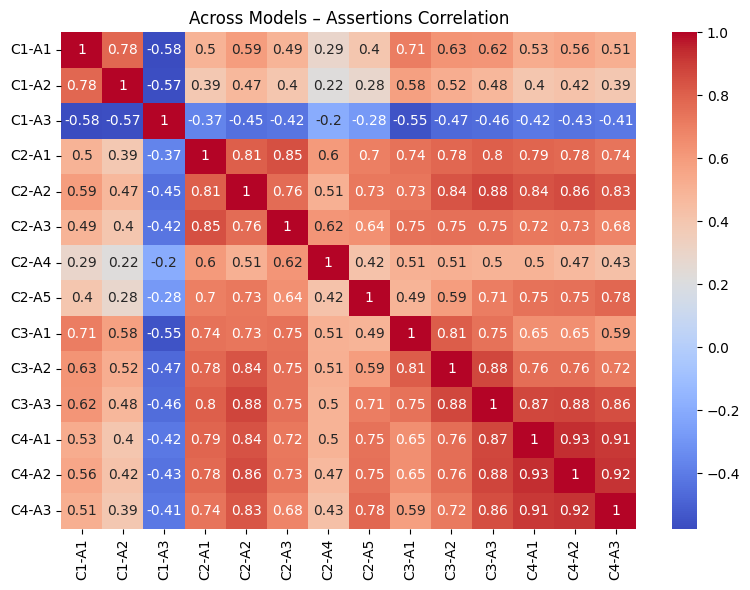

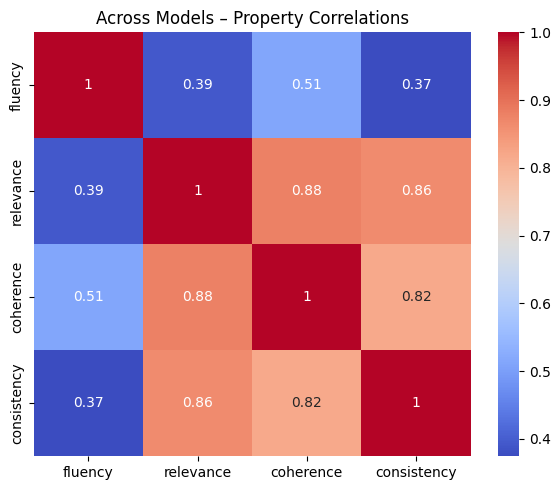

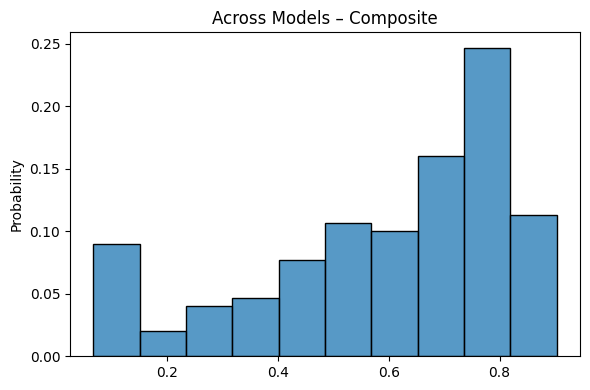

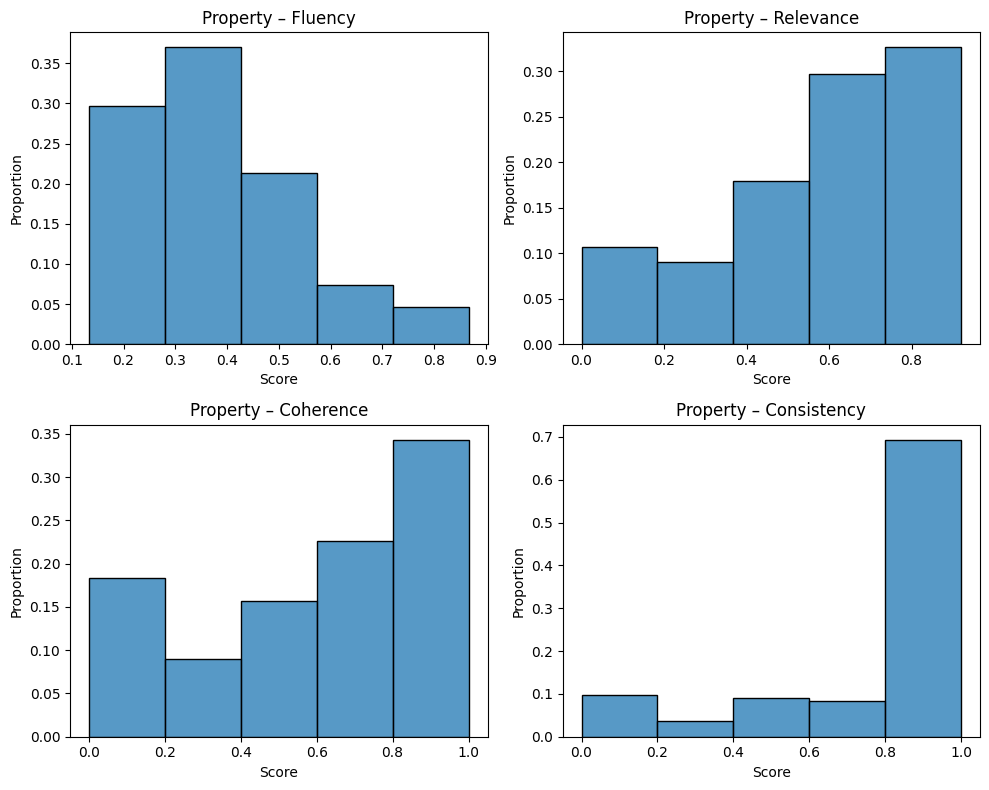

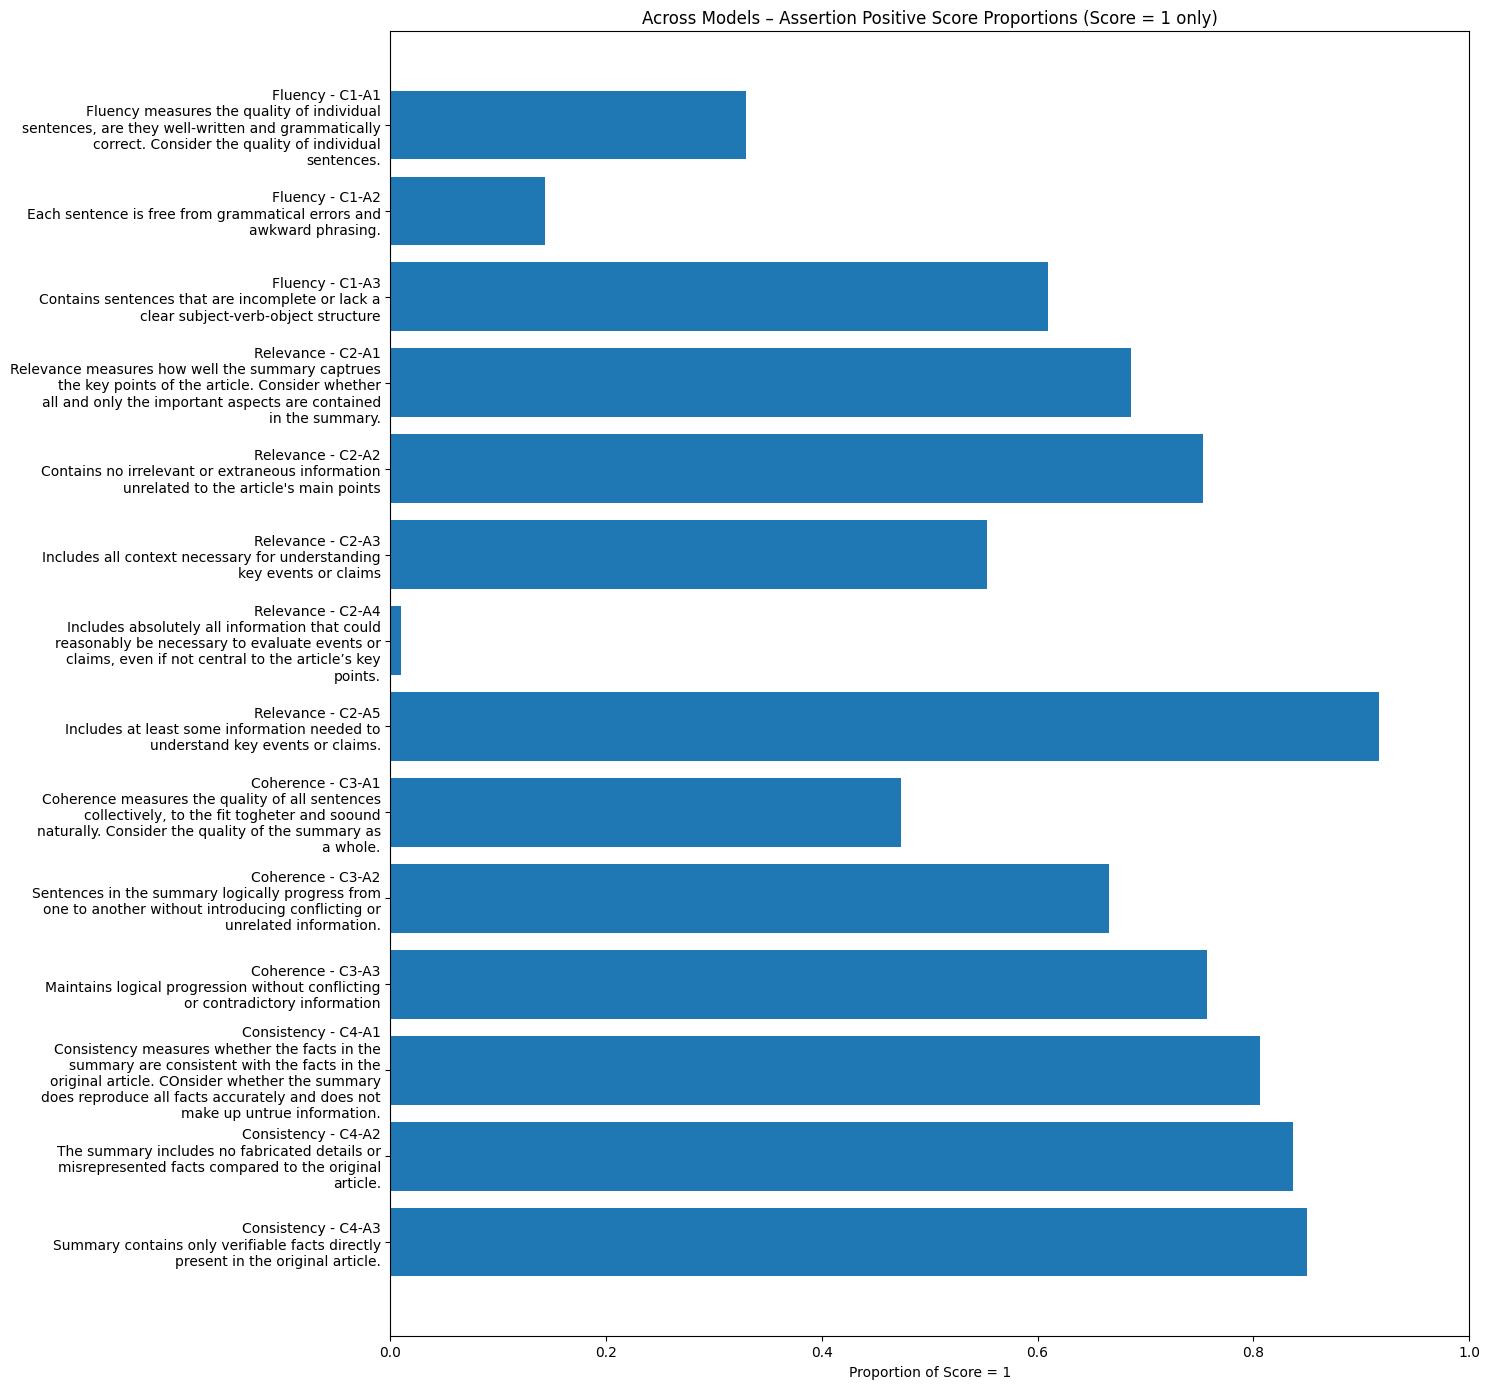

variance_per_assertion:
 [0.14533333 0.11573333 0.1752     0.1096     0.0984     0.14666667
 0.10933333 0.0504     0.12053333 0.09546667 0.08106667 0.0768
 0.07306667 0.0552    ] (14,)


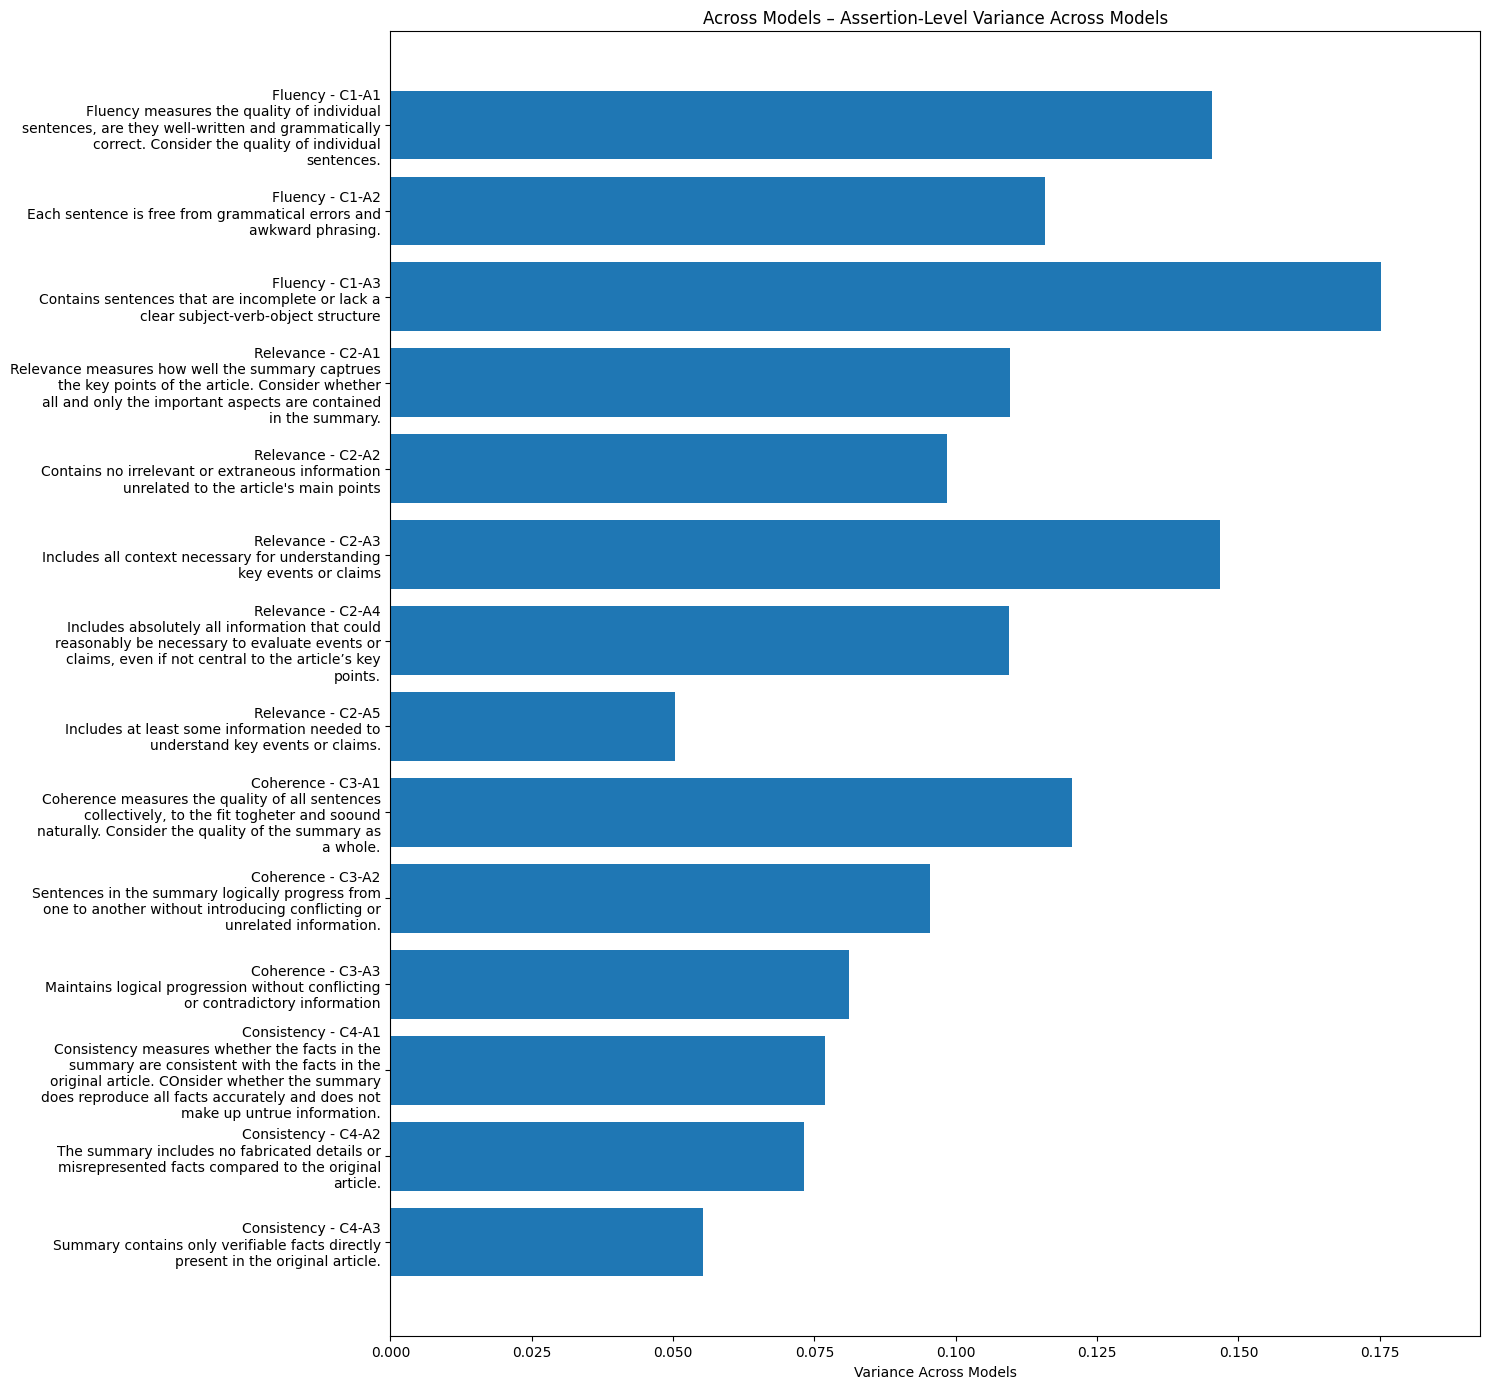

avg_scores_per_assertion shape: (5, 14)


In [13]:
cross_report = analyze_across_models(
    score_tables=score_tables,
    explain_tables=explain_tables,
    properties=properties,
    assertion_dictionary=assertion_dictionary
)

In [14]:
cross_report.keys()

dict_keys(['model_scores', 'model_explains', 'avg_across_models', 'avg_rating_per_assertion', 'property_scores_avg_models', 'property_corr_avg_models', 'composite_scores', 'model_variance', 'variance_per_assertion', 'avg_scores_per_assertion'])

# Add LLM stats to selected_df

In [ ]:
# # Ensure annotations are parsed from string to list of dicts (if not already)

# import ast

# DISC_THRESHOLD = 3

# for col in ["expert_annotations", "turker_annotations"]:
#     summ_eval_og[col] = summ_eval_og[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# # properties to evaluate
# properties = ["fluency", "relevance", "coherence", "consistency"]

# # Containers for new variance columns
# for prop in properties:
#     summ_eval_og[f"var_{prop}_expert"] = np.nan
#     summ_eval_og[f"var_{prop}_turker"] = np.nan
#     summ_eval_og[f"var_{prop}_all"] = np.nan
#     summ_eval_og[f"var_{prop}_expert_disc"] = np.nan
#     summ_eval_og[f"var_{prop}_turker_disc"] = np.nan
#     summ_eval_og[f"var_{prop}_all_disc"] = np.nan
#     summ_eval_og[f"scores_{prop}_expert"] = pd.Series([[]]*len(summ_eval_og), dtype=object)
#     summ_eval_og[f"scores_{prop}_turker"] = pd.Series([[]]*len(summ_eval_og), dtype=object)
#     summ_eval_og[f"scores_{prop}_all"] = pd.Series([[]]*len(summ_eval_og), dtype=object)
#     # summ_eval_og[f"scores_{prop}_llm"] = pd.Series([[]]*len(summ_eval_og), dtype=object)

# unique_crowd_scores = set()
# # Compute variances
# for idx, row in summ_eval_og.iterrows():
#     expert_ann = row["expert_annotations"]
#     if idx == 0: 
#         print(expert_ann)
#         # print(expert_ann.type)
#     turker_ann = row["turker_annotations"]

#     for prop in properties:
#         # Extract ratings
#         expert_scores = [ann[prop] for ann in expert_ann if prop in ann]
#         turker_scores = [ann[prop] for ann in turker_ann if prop in ann]
#         expert_scores_disc = [ann[prop] >= DISC_THRESHOLD for ann in expert_ann if prop in ann]
#         turker_scores_disc = [ann[prop] >= DISC_THRESHOLD for ann in turker_ann if prop in ann]

#         # unique_crowd_scores.update(turker_scores)
#         all_scores = expert_scores + turker_scores
#         all_scores_disc = expert_scores_disc + turker_scores_disc
#         # llm_scores = model_scores[:, idx, filtered_indices[prop]].tolist()

#         summ_eval_og.at[idx, f"scores_{prop}_expert"] = expert_scores
#         summ_eval_og.at[idx, f"scores_{prop}_turker"] = turker_scores
#         summ_eval_og.at[idx, f"scores_{prop}_all"] = all_scores
#         # summ_eval_og.at[idx, f"scores_{prop}_llm"] = llm_scores

#         if idx == 0: print(all_scores, all_scores_disc)
#         # Save variances (only if non-empty)
#         if len(expert_scores) > 1:
#             summ_eval_og.at[idx, f"var_{prop}_expert"] = np.var(expert_scores, ddof=1)
#             summ_eval_og.at[idx, f"var_{prop}_expert_disc"] = np.var(expert_scores_disc, ddof=1)
#         if len(turker_scores) > 1:
#             summ_eval_og.at[idx, f"var_{prop}_turker"] = np.var(turker_scores, ddof=1)
#             summ_eval_og.at[idx, f"var_{prop}_turker_disc"] = np.var(turker_scores_disc, ddof=1)
#         if len(all_scores) > 1:
#             summ_eval_og.at[idx, f"var_{prop}_all"] = np.var(all_scores, ddof=1)
#             summ_eval_og.at[idx, f"var_{prop}_all_disc"] = np.var(all_scores_disc, ddof=1)


# # print(unique_crowd_scores)


In [16]:
### START HERE

N_SUBSET = 300

# selected_df = summ_eval_og.sample(n=N_SUBSET, random_state=42).copy() ### reset indexing
selected_df.reset_index(drop=True, inplace=True) ### reset indexing
print(len(selected_df))

selected_indices = selected_df.index
print(selected_indices)

300
RangeIndex(start=0, stop=300, step=1)


In [17]:
model_scores = cross_report["model_scores"]
print(model_scores.shape)

model_variance = cross_report["model_variance"]
print(model_variance.shape)

model_explains = cross_report["model_explains"]
print(model_explains.shape)


(5, 300, 14)
(300, 14)
(5, 300, 14)


In [18]:
for prop in properties:
    selected_df[f"scores_{prop}_llm"] = pd.Series([[]]*len(selected_df), dtype=object)
    selected_df[f"var_{prop}_llm"] = np.nan
    selected_df[f"explanations_{prop}_llm"] = pd.Series([[] for _ in range(len(selected_df))], dtype=object)

for i in range(len(selected_df)):
    for prop, col_idx in filtered_indices.items():
        llm_scores = model_scores[:, i, col_idx].tolist()
        selected_df.at[i, f"scores_{prop}_llm"] = llm_scores

        llm_var = model_variance[i, col_idx]
        selected_df.at[i, f"var_{prop}_llm"] = llm_var

        llm_explains = list(model_explains[:, i, col_idx])
        selected_df.at[i, f"explanations_{prop}_llm"] = llm_explains
        
        if i == 0:
            print(llm_explains)
            print(f"{prop} – scores:", llm_scores)
            print(f"{prop} – variance:", llm_var)


['The summary contains several grammatical errors and lacks proper capitalization, making the sentences poorly constructed and less fluent.', 'The summary contains well-written and grammatically correct sentences that represent the main points of the article.', 'The summary contains grammatical errors (e.g., lowercase first letters, missing articles) and lacks fluency in sentence structure.', 'The summary contains grammatical errors (e.g., missing capitalization, awkward phrasing) and lacks fluency in sentence structure.', 'The summary contains grammatical errors and lacks proper sentence structure, such as missing capitalization and proper punctuation, which negatively impacts its fluency.']
fluency – scores: [0.0, 1.0, 0.0, 0.0, 0.0]
fluency – variance: 0.16000000000000006
["The summary is missing key points such as Lindegaard's off-pitch happiness, his Instagram post about his wife, and the detail about their son, which are important aspects of the article.", "The summary fails to c

In [25]:
selected_df.columns

Index(['summary', 'expert_annotations', 'turker_annotations', 'references',
       'model_id', 'raw', 'mistral_relevance', 'mistral_fluency',
       'mistral_coherence', 'mistral_consistency', 'all_annotations',
       'scores_coherence_expert', 'scores_coherence_turker',
       'scores_coherence_all', 'var_coherence_expert', 'var_coherence_turker',
       'var_coherence_all', 'mean_coherence_expert', 'mean_coherence_turker',
       'mean_coherence_all', 'var_coherence_expert_disc',
       'var_coherence_turker_disc', 'var_coherence_all_disc', 'diff_coherence',
       'scores_consistency_expert', 'scores_consistency_turker',
       'scores_consistency_all', 'var_consistency_expert',
       'var_consistency_turker', 'var_consistency_all',
       'mean_consistency_expert', 'mean_consistency_turker',
       'mean_consistency_all', 'var_consistency_expert_disc',
       'var_consistency_turker_disc', 'var_consistency_all_disc',
       'diff_consistency', 'scores_fluency_expert', 'scores_flu

# Plots: Human Raters (various) vs LLM

In [31]:
from scipy.stats import pearsonr

human_var_cols = {
    "fluency": "var_fluency_all",
    "relevance": "var_relevance_all",
    "coherence": "var_coherence_all",
    "consistency": "var_consistency_all"
}

expert_var_cols = {
    "fluency": "var_fluency_expert",
    "relevance": "var_relevance_expert",
    "coherence": "var_coherence_expert",
    "consistency": "var_consistency_expert"
}

crowd_var_cols = {
    "fluency": "var_fluency_turker",
    "relevance": "var_relevance_turker",
    "coherence": "var_coherence_turker",
    "consistency": "var_consistency_turker"
}

llm_var_cols = {
    "fluency": "var_fluency_llm",
    "relevance": "var_relevance_llm",
    "coherence": "var_coherence_llm",
    "consistency": "var_consistency_llm"
}

all_human_versions = {
    "human_var_cols": ("All Human Raters", human_var_cols),
    "expert_var_cols": ("Expert Raters Only", expert_var_cols),
    "crowd_var_cols": ("Crowdsource Raters Only", crowd_var_cols),
}

In [32]:
filtered_indices

{'fluency': 0, 'relevance': 3, 'coherence': 8, 'consistency': 11}

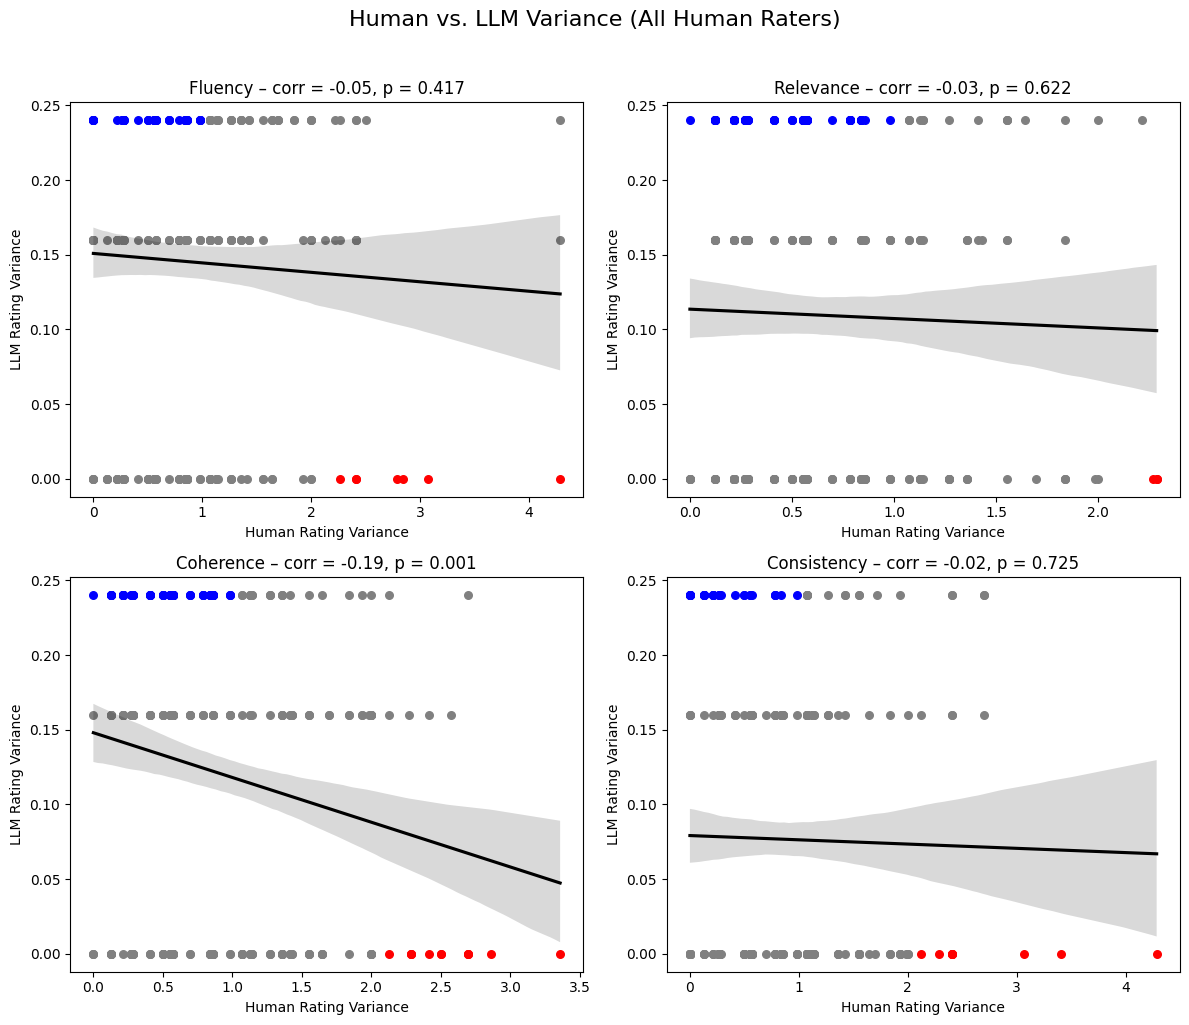

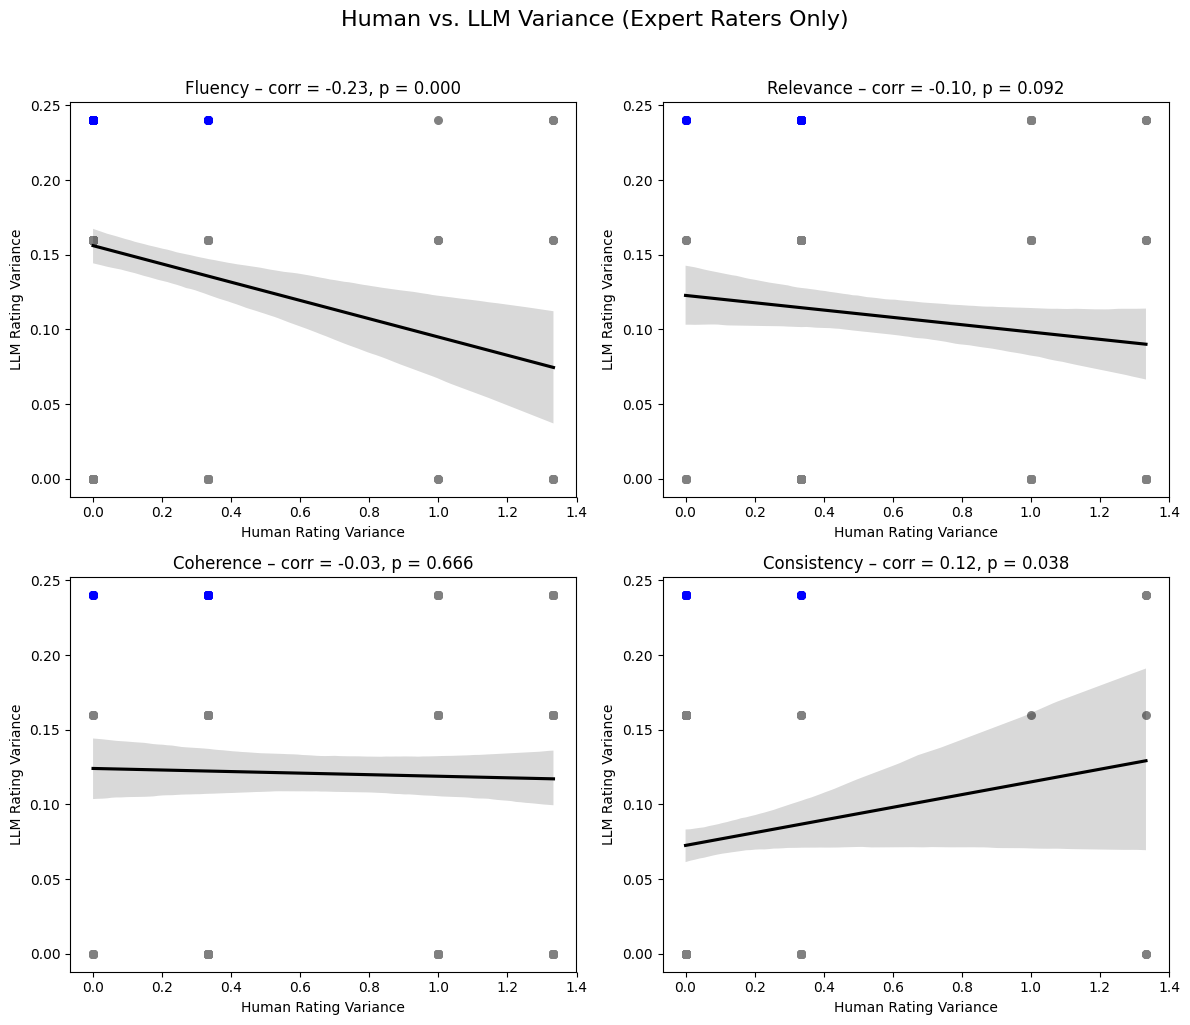

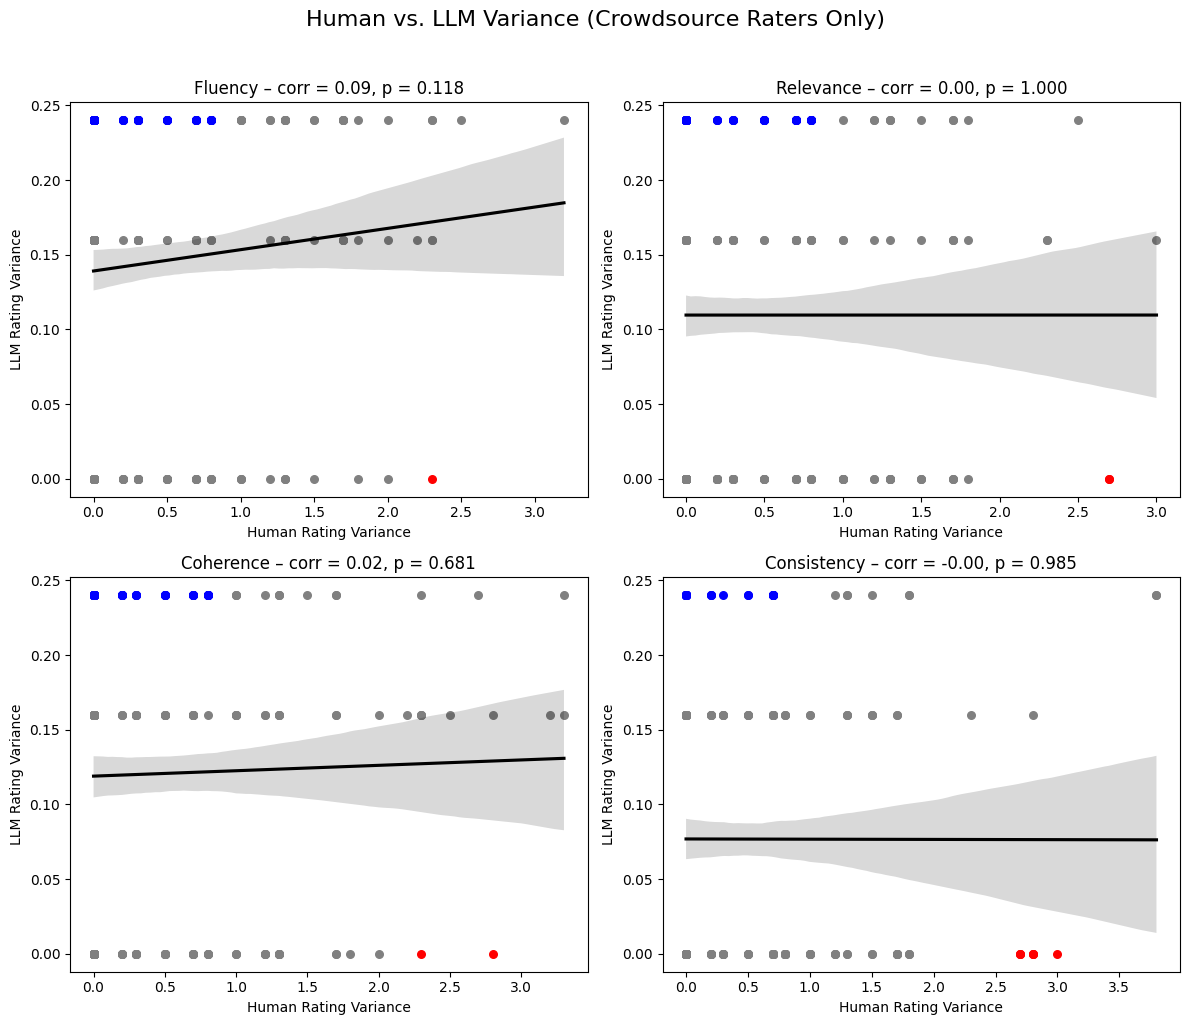

In [33]:
curr_var = human_var_cols ### Change as needed

HUMAN_LOW = 1.0
HUMAN_HIGH = 2.0
LLM_LOW = 0.1
LLM_HIGH = 0.2

for var_key, (title_str, curr_var) in all_human_versions.items():
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (prop, model_var_col_idx) in enumerate(filtered_indices.items()):
        # Human variance for this property
        human_var = selected_df[curr_var[prop]].values
        # LLM variance for this property
        llm_var = model_variance[:, model_var_col_idx]

        corr, pval = pearsonr(human_var, llm_var)

        upper_left_mask = (human_var < HUMAN_LOW) & (llm_var > LLM_HIGH)
        lower_right_mask = (human_var > HUMAN_HIGH) & (llm_var < LLM_LOW)
        other_mask = ~(upper_left_mask | lower_right_mask)

        ax = axes[idx]
        ax.scatter(human_var[other_mask], llm_var[other_mask], color='gray', s=30)
        ax.scatter(human_var[upper_left_mask], llm_var[upper_left_mask], color='blue', s=30)
        ax.scatter(human_var[lower_right_mask], llm_var[lower_right_mask], color='red', s=30)

        # Regression line
        sns.regplot(x=human_var, y=llm_var, ax=ax, scatter=False, line_kws={"color": "black"})

        ax.set_title(f"{prop.capitalize()} – corr = {corr:.2f}, p = {pval:.3f}")
        ax.set_xlabel("Human Rating Variance")
        ax.set_ylabel("LLM Rating Variance")

    fig.suptitle(f"Human vs. LLM Variance ({title_str})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Human vs LLM Disagreement Case Analysis
Below anaylsis is only for all human raters case.\
Change curr_var where indicated for experts only/ crowdsource only cases.

In [ ]:
results = {}

curr_var = human_var_cols ### Change as needed

for prop in properties:
    human_var = selected_df[curr_var[prop]].values
    llm_var = selected_df[llm_var_cols[prop]].values

    upper_left_mask = (human_var < HUMAN_LOW) & (llm_var > LLM_HIGH)
    lower_right_mask = (human_var > HUMAN_HIGH) & (llm_var < LLM_LOW)

    upper_left_indices = np.where(upper_left_mask)[0]
    lower_right_indices = np.where(lower_right_mask)[0]

    results[prop] = {
        "upper_left_count": len(upper_left_indices),
        "lower_right_count": len(lower_right_indices),
        "upper_left_items": upper_left_indices,
        "lower_right_items": lower_right_indices
    }

    print(f"{prop.capitalize()}:")
    print(f"  Upper Left (Low Human, High LLM): {len(upper_left_indices)}")
    print(f"  Lower Right (High Human, Low LLM): {len(lower_right_indices)}\n")


Fluency:
  Upper Left (Low Human, High LLM): 72
  Lower Right (High Human, Low LLM): 7

Relevance:
  Upper Left (Low Human, High LLM): 70
  Lower Right (High Human, Low LLM): 3

Coherence:
  Upper Left (Low Human, High LLM): 67
  Lower Right (High Human, Low LLM): 12

Consistency:
  Upper Left (Low Human, High LLM): 30
  Lower Right (High Human, Low LLM): 9



In [ ]:
### Example for Fluency upper left, change variable where indicated as needed

curr_quadrant = "upper_left_items" ### Change as needed
curr_prop = "fluency" ### Change as needed

quad_prop_indices = results[curr_prop][curr_quadrant]
quad_prop_df = selected_df.iloc[quad_prop_indices]

print(quad_prop_df.iloc[0])


summary                         vanessa santillan's body was found in a £400,0...
expert_annotations              [{'coherence': 5, 'consistency': 5, 'fluency':...
turker_annotations              [{'coherence': 5, 'consistency': 5, 'fluency':...
references                      ['Vanessa Santillan was found dead at a flat i...
model_id                                                                      M23
                                                      ...                        
var_coherence_llm                                                             0.0
explanations_coherence_llm      [The summary effectively captures the key deta...
scores_consistency_llm                                  [1.0, 1.0, 1.0, 1.0, 1.0]
var_consistency_llm                                                           0.0
explanations_consistency_llm    [The summary accurately reflects all key facts...
Name: 4, Length: 75, dtype: object


In [47]:
output_dir = "../results/human_llm_disagreement_examples"
os.makedirs(output_dir, exist_ok=True)

for prop in properties:
    # Extract index arrays
    upper_left_indices = results[prop]["upper_left_items"]
    lower_right_indices = results[prop]["lower_right_items"]

    # Subset the selected_df
    upper_left_df = selected_df.iloc[upper_left_indices].copy()
    lower_right_df = selected_df.iloc[lower_right_indices].copy()

    # Choose relevant columns to export
    cols = [
        "summary", "raw", "references",
        f"scores_{prop}_all", f"var_{prop}_all",
        f"scores_{prop}_llm", f"var_{prop}_llm",
        f"explanations_{prop}_llm"
    ]
    
    # Fallback in case some columns are missing (skip quietly)
    export_cols = [col for col in cols if col in selected_df.columns]

    # Save to CSV
    upper_left_df[export_cols].to_csv(os.path.join(output_dir, f"upper_left_{prop}.csv"), index=False)
    lower_right_df[export_cols].to_csv(os.path.join(output_dir, f"lower_right_{prop}.csv"), index=False)

    print(f"[OK]: Saved {prop}: {len(upper_left_df)} upper left, {len(lower_right_df)} lower right")

[OK]: Saved fluency: 72 upper left, 7 lower right
[OK]: Saved relevance: 70 upper left, 3 lower right
[OK]: Saved coherence: 67 upper left, 12 lower right
[OK]: Saved consistency: 30 upper left, 9 lower right


# Plot: Expert vs Crowd Correlation

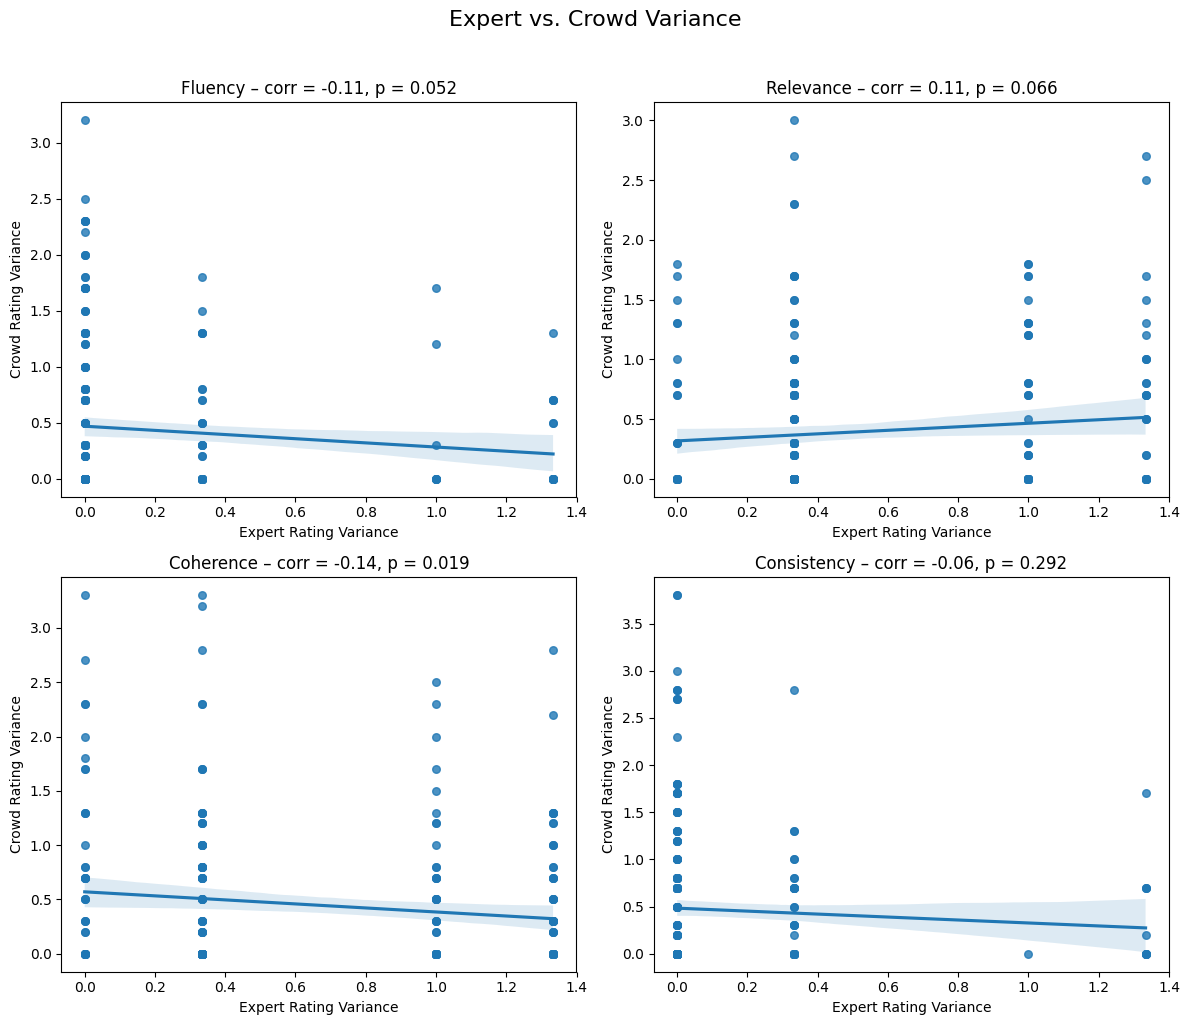

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()


for idx, (prop, model_var_col_idx) in enumerate(filtered_indices.items()):
    expert_var = selected_df[expert_var_cols[prop]].values
    crowd_var = selected_df[crowd_var_cols[prop]].values

    corr, pval = pearsonr(expert_var, crowd_var)

    sns.regplot(x=expert_var, y=crowd_var, ax=axes[idx], scatter_kws={'s': 30})
    axes[idx].set_title(f"{prop.capitalize()} – corr = {corr:.2f}, p = {pval:.3f}")
    axes[idx].set_xlabel("Expert Rating Variance")
    axes[idx].set_ylabel("Crowd Rating Variance")

plt.suptitle("Expert vs. Crowd Variance", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Ver 3: Human vs LLM with Threshold

In [41]:
human_var_cols_disc = {
    "fluency": "var_fluency_all_disc",
    "relevance": "var_relevance_all_disc",
    "coherence": "var_coherence_all_disc",
    "consistency": "var_consistency_all_disc"
}

expert_var_cols_disc = {
    "fluency": "var_fluency_expert_disc",
    "relevance": "var_relevance_expert_disc",
    "coherence": "var_coherence_expert_disc",
    "consistency": "var_consistency_expert_disc"
}

crowd_var_cols_disc = {
    "fluency": "var_fluency_turker_disc",
    "relevance": "var_relevance_turker_disc",
    "coherence": "var_coherence_turker_disc",
    "consistency": "var_consistency_turker_disc"
}

all_human_versions = {
    "human_var_cols_disc": ("All Human Raters", human_var_cols_disc),
    "expert_var_cols": ("Expert Raters Only", expert_var_cols_disc),
    "crowd_var_cols_disc": ("Crowdsource Raters Only", crowd_var_cols_disc),
}

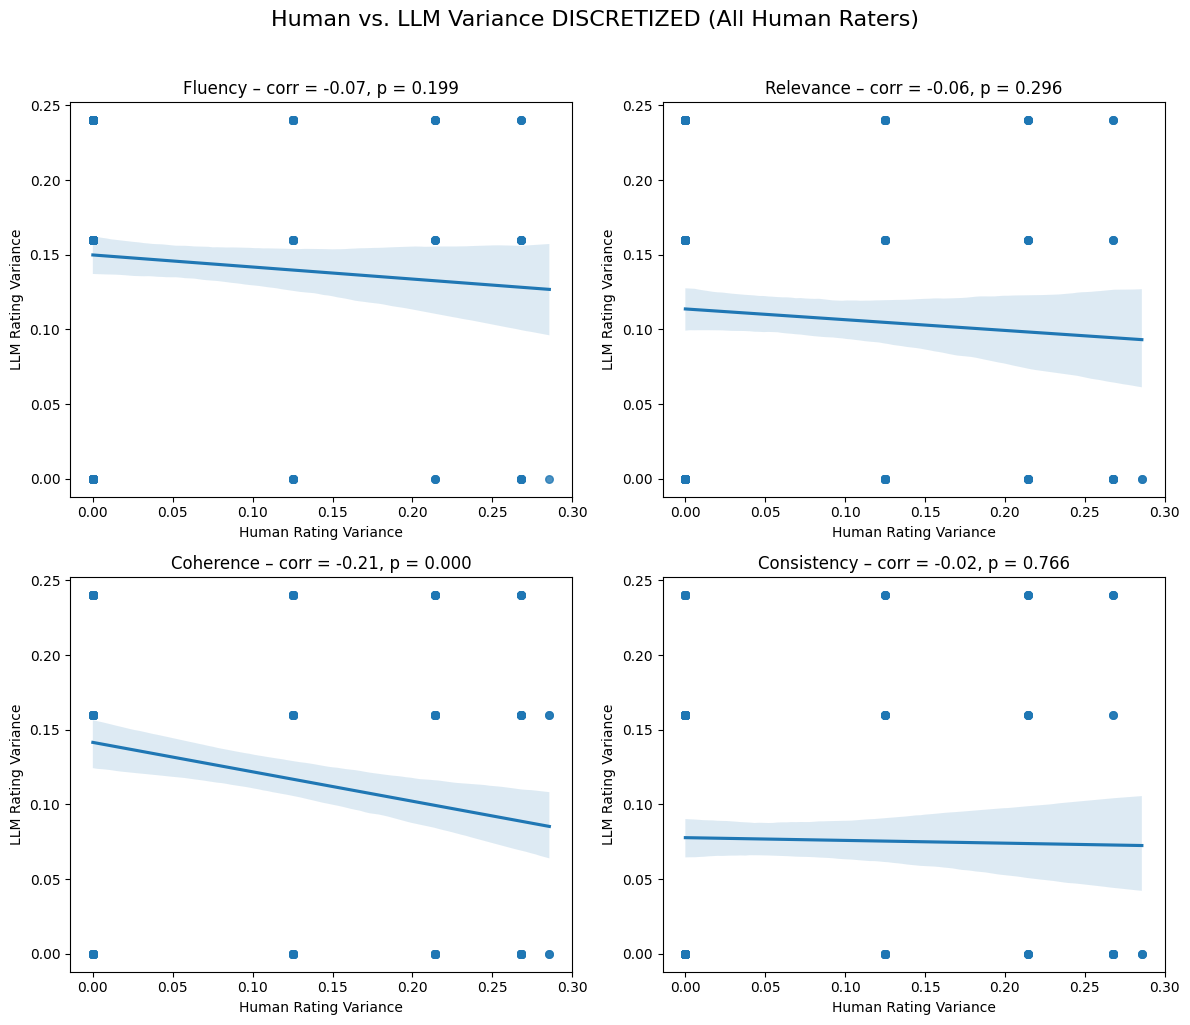

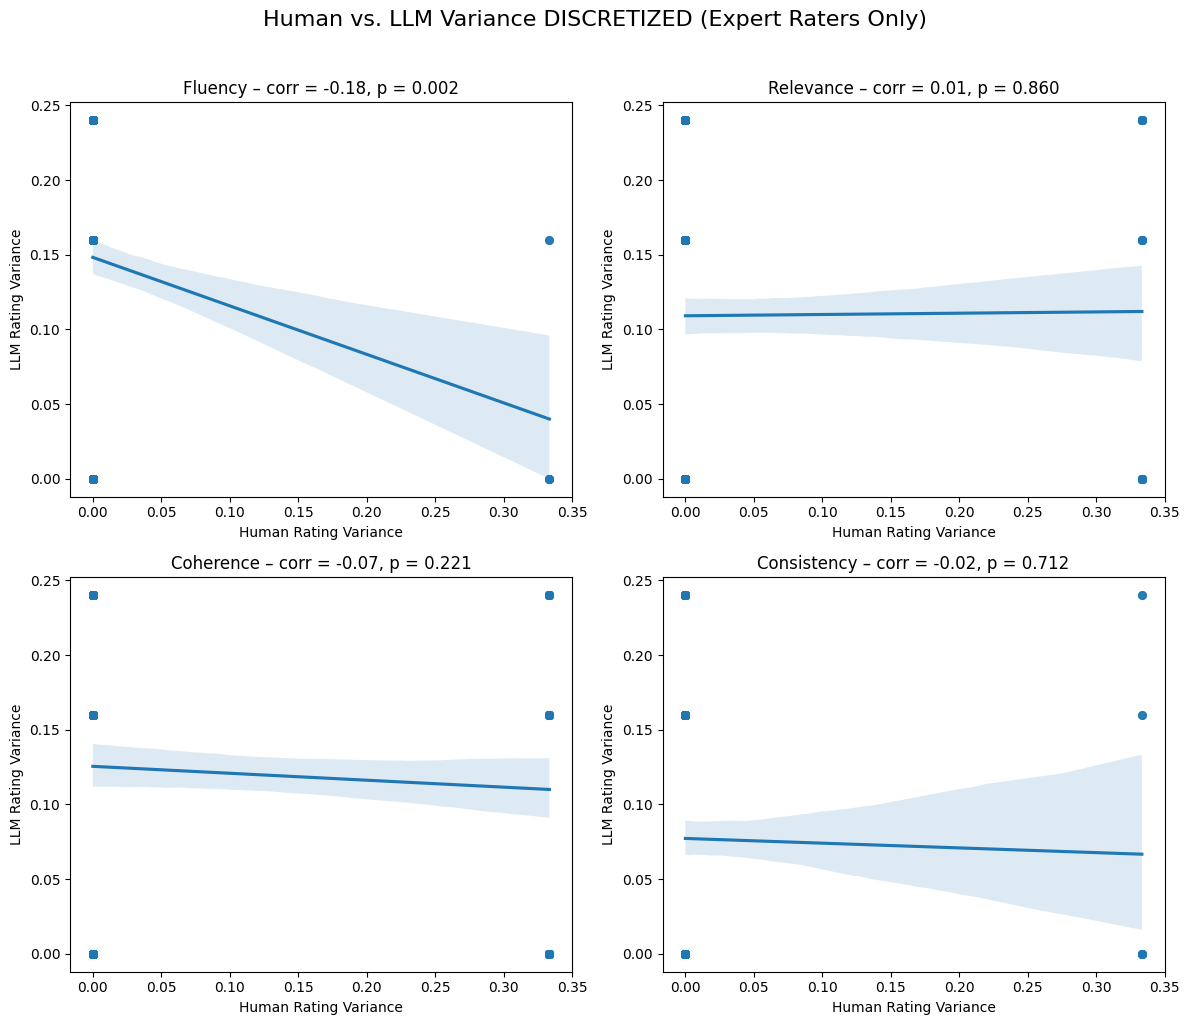

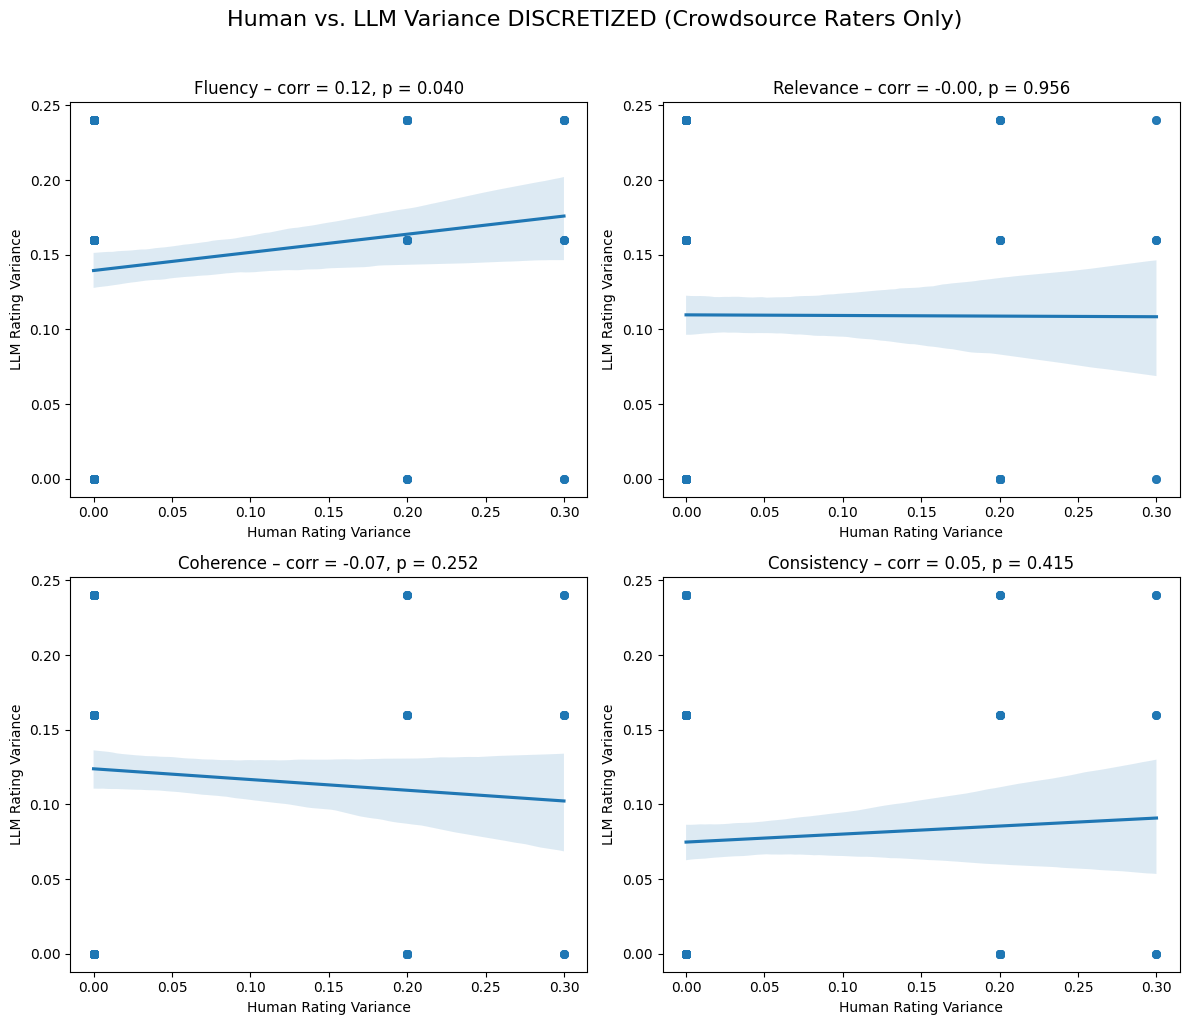

In [44]:
for var_key, (title_str, curr_var) in all_human_versions.items():
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (prop, model_var_col_idx) in enumerate(filtered_indices.items()):
        # X = human rating variance for this prop
        human_var = selected_df[curr_var[prop]].values

        # Y = LLM model score variance for the selected assertion
        llm_var = model_variance[:, model_var_col_idx]

        # Compute correlation
        corr, pval = pearsonr(human_var, llm_var)

        # Plot regression + points
        sns.regplot(x=human_var, y=llm_var, ax=axes[idx], scatter_kws={'s': 30})
        axes[idx].set_title(f"{prop.capitalize()} – corr = {corr:.2f}, p = {pval:.3f}")
        axes[idx].set_xlabel("Human Rating Variance")
        axes[idx].set_ylabel("LLM Rating Variance")

    fig.suptitle(f"Human vs. LLM Variance DISCRETIZED ({title_str})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

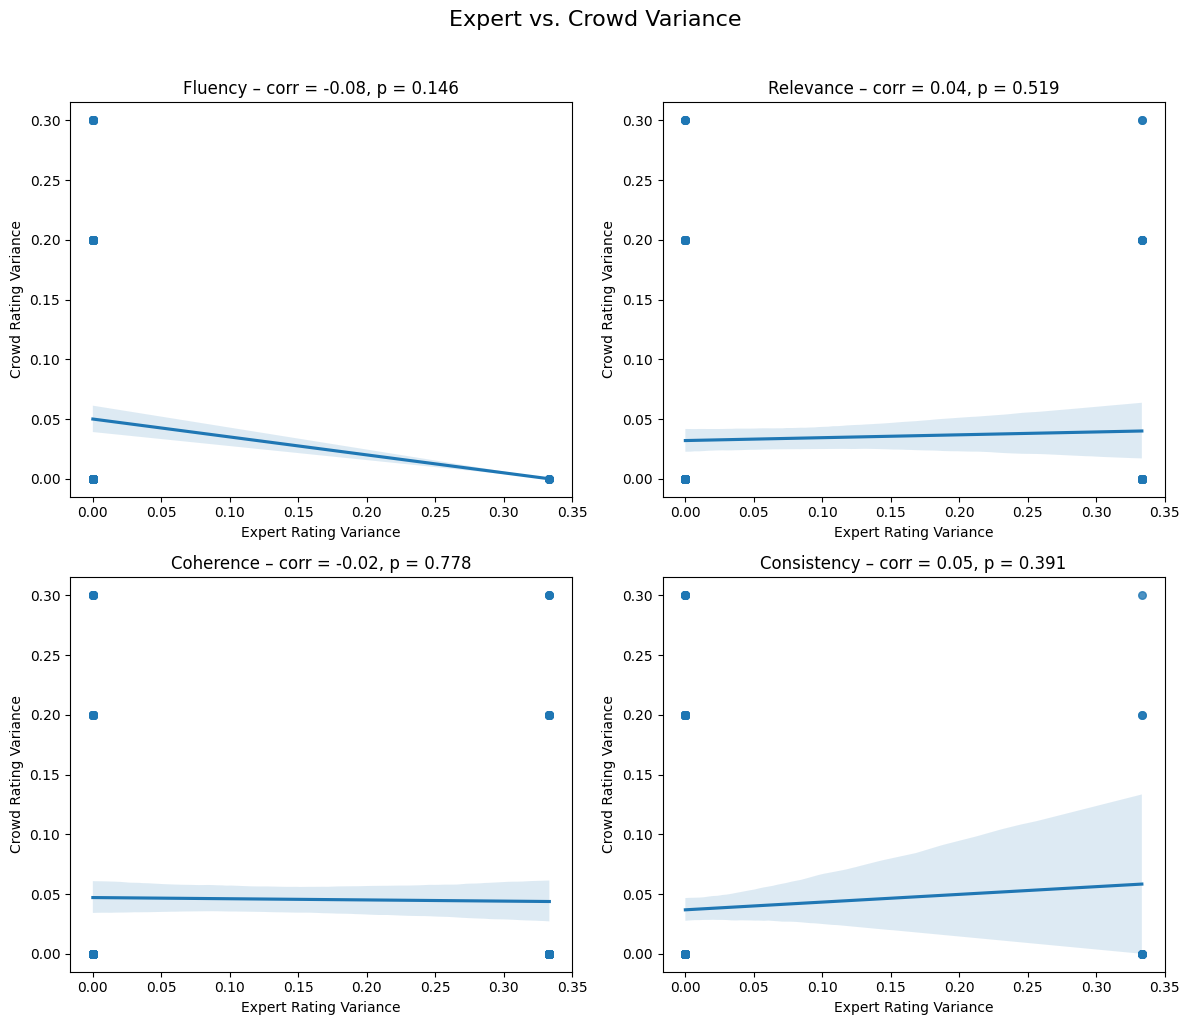

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (prop, model_var_col_idx) in enumerate(filtered_indices.items()):
    expert_var = selected_df[expert_var_cols_disc[prop]].values
    crowd_var = selected_df[crowd_var_cols_disc[prop]].values

    corr, pval = pearsonr(expert_var, crowd_var)

    sns.regplot(x=expert_var, y=crowd_var, ax=axes[idx], scatter_kws={'s': 30})
    axes[idx].set_title(f"{prop.capitalize()} – corr = {corr:.2f}, p = {pval:.3f}")
    axes[idx].set_xlabel("Expert Rating Variance")
    axes[idx].set_ylabel("Crowd Rating Variance")

plt.suptitle("Expert vs. Crowd Variance", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()